In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
import sys
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models
from tensorflow.keras import layers
from tqdm import tqdm

2023-09-30 07:53:42.707789: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-30 07:53:42.737801: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-09-30 07:53:42.737835: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-09-30 07:53:42.737848: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-30 07:53:42.742941: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-30 07:53:42.743954: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

# Important Functions

In [3]:
def get_file_list(directory) -> list:
    return os.listdir(directory)

def unique_items_in_list(list1):
    # insert the list to the set
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    
    return unique_list

# Check out Unique Patients in the AD_time_to_dx.csv file

In [4]:
df_labels = pd.read_csv("data/AD_time_to_dx.csv")

full_patients_list = df_labels["PTID"].values

print(f"Number of patients in AD_time_to_dx.csv: {len(unique_items_in_list(full_patients_list))}\n\n")

print(f"List of {len(unique_items_in_list(full_patients_list))} Patients:\n")
print(*full_patients_list, sep=", ")

Number of patients in AD_time_to_dx.csv: 495


List of 495 Patients:

022_S_0004, 011_S_0005, 100_S_0006, 022_S_0014, 100_S_0015, 011_S_0016, 067_S_0019, 011_S_0021, 011_S_0022, 011_S_0023, 023_S_0030, 023_S_0031, 035_S_0033, 100_S_0035, 067_S_0038, 099_S_0040, 007_S_0041, 023_S_0042, 018_S_0043, 100_S_0047, 035_S_0048, 123_S_0050, 099_S_0051, 099_S_0054, 067_S_0056, 018_S_0057, 023_S_0058, 067_S_0059, 099_S_0060, 023_S_0061, 022_S_0066, 010_S_0067, 007_S_0068, 100_S_0069, 007_S_0070, 123_S_0072, 027_S_0074, 067_S_0077, 018_S_0080, 023_S_0081, 136_S_0086, 018_S_0087, 073_S_0089, 099_S_0090, 032_S_0095, 022_S_0096, 020_S_0097, 067_S_0098, 007_S_0101, 123_S_0106, 136_S_0107, 123_S_0108, 099_S_0111, 127_S_0112, 123_S_0113, 027_S_0116, 027_S_0118, 027_S_0120, 131_S_0123, 041_S_0125, 023_S_0126, 068_S_0127, 007_S_0128, 022_S_0130, 021_S_0141, 018_S_0142, 037_S_0150, 018_S_0155, 035_S_0156, 137_S_0158, 021_S_0159, 098_S_0160, 114_S_0166, 011_S_0168, 014_S_0169, 098_S_0171, 098_S_0172, 114_S_

# Script to get patient ids and scan dates

### After downloading the meta data of all MRI scans of all patient in the AD_time_to_dx.csv file, this script explores the most common types of scans and their dates

In [5]:
METADATA_ROOT_PATH = "data/Patients_in_AD_time_to_dx_metadata"

df = None

# dictionary with list object in values
df_dict = {
    'patient_id' : [],
    'group' : [],
    'scan_date' : []
}

full_patient_ids = get_file_list(METADATA_ROOT_PATH)

for i in tqdm(range(len(full_patient_ids))):
    pid = full_patient_ids[i]
    GROUP_DIR_PATH = METADATA_ROOT_PATH + "/" + pid

    # Ignore non-directory metadata at this level
    if not os.path.isdir(GROUP_DIR_PATH):
        continue

    group_list = get_file_list(GROUP_DIR_PATH)

    for group in group_list:
        DATE_PATH = GROUP_DIR_PATH + "/" + group
            
        date_list = get_file_list(DATE_PATH)
    
        for date in date_list:
            df_dict["patient_id"].append(pid)
            df_dict["group"].append(group)
            df_dict["scan_date"].append(date)
            

# creating a Dataframe object 
df = pd.DataFrame(df_dict)

df.to_csv("\data\adni_patient_scan_dates.csv")

print(df.head())

print(f"\n\nNumber of distinct patients in metadata = {len(df.patient_id.unique())}\n")

df_groups = df.groupby('group')

# For debugging purposes
sorted_df_groups = df.group.unique()
sorted_df_groups.sort()

print("Number of unique patients per scan group:")
print(df_groups['patient_id'].nunique().sort_values(ascending=False), end="\n\n")

mprage_patient_list = df_groups.get_group('MPRAGE')['patient_id'].unique()

print("Patient IDs with MPRAGE scans:\n")
print(mprage_patient_list)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35212/35212 [00:34<00:00, 1019.09it/s]


   patient_id              group              scan_date
0  002_S_0295  3-plane_localizer  2006-04-18_08_19_08.0
1  002_S_0295  3-plane_localizer  2006-11-02_08_15_08.0
2  002_S_0295  3-plane_localizer  2007-05-25_07_06_39.0
3  002_S_0295  3-plane_localizer  2007-05-25_07_10_07.0
4  002_S_0295  3-plane_localizer  2008-07-23_14_49_54.0


Number of distinct patients in metadata = 495

Number of unique patients per scan group:
group
MPRAGE                  311
MPRAGE_Repeat           247
Axial_PD-T2_TSE         246
MP-RAGE                 241
B1-calibration_Head     231
                       ... 
DOUBLE_TSE_SENSE          1
Double_TSE-3rdRepeat      1
Double_TSE-repeat         1
FLAIR                     1
tgse_pcasl_PLD2000        1
Name: patient_id, Length: 352, dtype: int64

Patient IDs with MPRAGE scans:

['002_S_0295' '002_S_0413' '002_S_0685' '002_S_0729' '002_S_0954'
 '002_S_1070' '002_S_1155' '002_S_1261' '002_S_1268' '002_S_1280'
 '003_S_0907' '003_S_0908' '003_S_0981' '003_S_105

#### It seems that among the 495 patients in the list, MPRAGE is the most common type of scan that they have (311 out of 495 patients)

AD_dx_in_5_yrs
0    218
1     93
Name: count, dtype: int64


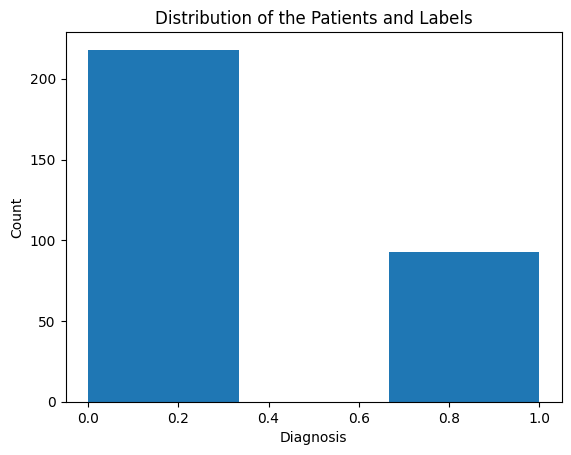

In [6]:
df_mprage_labels = df_labels[df_labels['PTID'].isin(mprage_patient_list)]

diagnosis_value_counts = df_mprage_labels['AD_dx_in_5_yrs'].value_counts()

print(diagnosis_value_counts)

plt.hist(df_mprage_labels['AD_dx_in_5_yrs'], bins=3)
plt.title('Distribution of the Patients and Labels')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

## Sample the Amount of Patients for an even split between 0 and 1

### Because my RAM can't handle the entire dataset

In [7]:
patients_AD_dx_in_5_yrs_0_list = df_mprage_labels[df_mprage_labels['AD_dx_in_5_yrs'] == 0]['PTID'].unique()[0:93]
patients_AD_dx_in_5_yrs_1_list = df_mprage_labels[df_mprage_labels['AD_dx_in_5_yrs'] == 1]['PTID'].unique()[0:93]
filtered_patients_list = np.concatenate((patients_AD_dx_in_5_yrs_0_list, patients_AD_dx_in_5_yrs_1_list), axis=0)

print(f"{len(patients_AD_dx_in_5_yrs_0_list)} patients with 0 value\n{len(patients_AD_dx_in_5_yrs_1_list)} patients with 1 value")

93 patients with 0 value
93 patients with 1 value


# Test Generating MRI Data Array for MPRAGE Scans

## Get Maximum number of images of a patient has in an MPRAGE Scan and show the distribution

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 311/311 [00:02<00:00, 143.29it/s]


Number of patients: 186

Most number of images in an MP-RAGE scan: 184

Least number of images in an MP-RAGE scan: 160



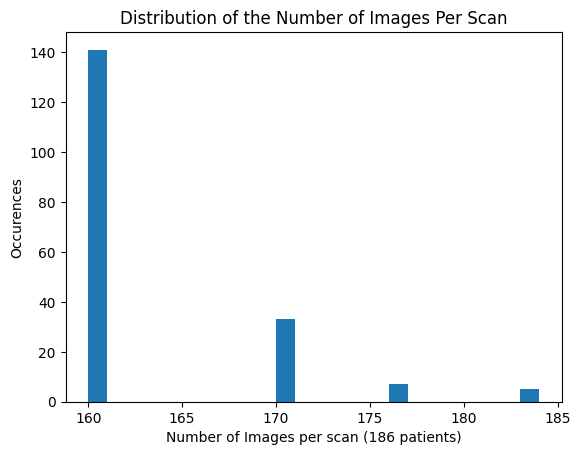

In [8]:
DATA_PATH = 'data/MPRAGE_data'

patient_list = get_file_list(DATA_PATH)

list_of_image_quantities = list()

for i in tqdm(range(len(patient_list))):
    patient_id = patient_list[i]

    # temporarily limit amount of data
    if patient_id not in filtered_patients_list:
        continue
    
    PATIENT_ID_PATH = DATA_PATH + "/" + patient_id
    
    scan_list = get_file_list(PATIENT_ID_PATH)

    is_group_scanned = False
    
    for scan_group in scan_list:
        
        # Scan first group only
        if is_group_scanned:
            continue
            
        if scan_group != "MPRAGE":
            continue
        else:
            is_group_scanned = True
            
            array_list = list()

            SCAN_PATH = PATIENT_ID_PATH + "/" + scan_group

            date_list = get_file_list(SCAN_PATH)

            date_list.sort()
            
            is_date_scanned = False
            
            for date in date_list:

                # Use the first date only
                if is_date_scanned:
                    continue

                is_date_scanned = True
                
                DATE_PATH = SCAN_PATH + "/" + date

                id_list = get_file_list(DATE_PATH)

                is_id_scanned = False
                
                for id in id_list:

                    # Scan first ID only
                    if is_id_scanned:
                        continue
            
                    is_id_scanned = True
                    
                    ID_PATH = DATE_PATH + "/" + id
                
                    file_list = get_file_list(ID_PATH)

                    list_of_image_quantities.append(len(file_list))

max_images = max(list_of_image_quantities) # Use this variable in the next step
min_images = min(list_of_image_quantities)

print(f"Number of patients: {len(list_of_image_quantities)}\n")
print(f"Most number of images in an MP-RAGE scan: {max_images}\n")
print(f"Least number of images in an MP-RAGE scan: {min_images}\n")

plt.hist(list_of_image_quantities, bins=(max_images-min_images))
plt.title('Distribution of the Number of Images Per Scan')
plt.xlabel(f'Number of Images per scan ({len(list_of_image_quantities)} patients)')
plt.ylabel('Occurences')
plt.show()

## Build Data and Label Arrays

### The Data array is a 3D array that is a list of 256 x 256 pixel arrays (N x 256 x 256)
### The Label array is a 2D array that is a list of single-digit labels (N x 1)

In [19]:
DATA_PATH = 'data/MPRAGE_data'

# Create look-up dictionary for labels {"patient_id" : "AD_dx_in_5_yrs"}
patient_label_dict = df_labels[['PTID','AD_dx_in_5_yrs']].set_index('PTID').to_dict()['AD_dx_in_5_yrs']

patient_list = get_file_list(DATA_PATH)

# Delete arrays if they exist
if data_array:
    del data_array
    
if label_array:
    del label_array


data_list = list()
label_list = list()

for i in tqdm(range(len(patient_list))):
    
    patient_id = patient_list[i]
    
    # temporarily limit amount of data
    # if patient_id not in filtered_patients_list:
    #     continue
    
    PATIENT_ID_PATH = DATA_PATH + "/" + patient_id
    
    scan_list = get_file_list(PATIENT_ID_PATH)
    
    is_group_scanned = False
    
    for scan_group in scan_list:

        # Scan first group only
        if is_group_scanned:
            continue
        
        if scan_group != "MPRAGE":
            continue
        else:
            is_group_scanned = True

            SCAN_PATH = PATIENT_ID_PATH + "/" + scan_group

            date_list = get_file_list(SCAN_PATH)

            date_list.sort()
            
            is_date_scanned = False
            
            for date in date_list:

                # Use the first date only
                if is_date_scanned:
                    continue
                is_date_scanned = True
                
                DATE_PATH = SCAN_PATH + "/" + date

                id_list = get_file_list(DATE_PATH)

                is_id_scanned = False
                
                for id in id_list:

                    # Scan first ID only
                    if is_id_scanned:
                        continue
            
                    is_id_scanned = True
                    
                    ID_PATH = DATE_PATH + "/" + id
                
                    file_list = get_file_list(ID_PATH)
                    
                    for file_name in file_list:
                        np.set_printoptions()
                        file_path = ID_PATH + "/" + file_name
        
                        dcm = pydicom.dcmread(file_path)
                        
                        pixel_array = dcm.pixel_array

                        # Resize to (256, 256)
                        if str(pixel_array.shape) != "(256, 256)":
                            #print(pixel_array.shape)
                            pixel_array = np.resize(pixel_array, (256, 256))
                            #print(pixel_array.shape)
                            
                        # array_list.append(pixel_array)
                        
                        data_list.append(pixel_array)
                        label_list.append(patient_label_dict[patient_id])

                    # Fill missing spaces with arrays
                    # cur_len = len(array_list)

                    # for j in range(max_images-cur_len):
                    #     array_list.append(np.zeros(shape=(256, 256)))

    # output_list.append(array_list)

data_array = np.array(data_list)
label_array = np.array(label_list)
print("Data Array Shape" + str(data_array.shape))
print("Data Array Size: %d bytes" % (data_array. size * data_array. itemsize))
print("Data Array Size: %d GiB" % (data_array. size * data_array. itemsize / 1073741824))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 311/311 [06:39<00:00,  1.28s/it]


Data Array Shape(50724, 256, 256)
Data Array Size: 6648496128 bytes
Data Array Size: 6 GiB


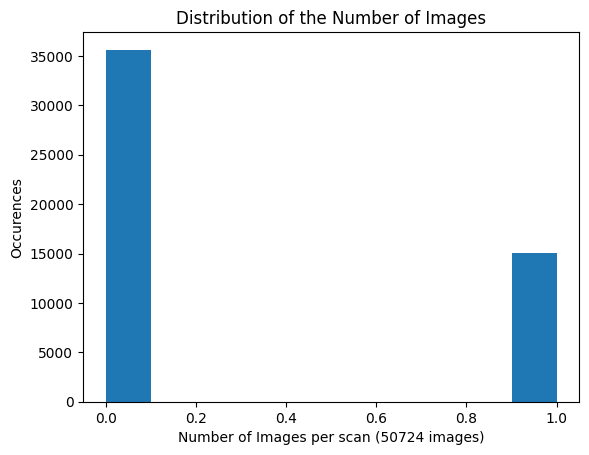

In [20]:
plt.hist(label_array)
plt.title('Distribution of the Number of Images')
plt.xlabel(f'Number of Images per scan ({len(label_array)} images)')
plt.ylabel('Occurences')
plt.show()

# Train Test Split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(data_array, label_array,
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True,
                                   stratify=label_array
                                  )

NameError: name 'train_test_split' is not defined

# Build Model

### Copy-pasted from the "FFNN_DiabeticRetinopathy" notebook

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

# first layer: input
input1 = tf.keras.layers.Input(shape=(224, 224, 1), name='Input')

# second layer: flatten (transforms the format of the images (to a 1D array of 224*224 = 50176 pixels)
# this layer has no params or weights to learn, it only reformats data
input2 = tf.keras.layers.Flatten(name='Flatten')(input1)
    
# third layer: dense (i.e., the nodes are fully connected)
# this layer has 12544 nodes (112 x 112 image), and it uses the activation function Rectified Linear Unit
input3 = tf.keras.layers.Dense(units=12544, activation='relu', name='fc_1')(input2)
    
# forth layer: dense (i.e., the nodes are fully connected)
# this layer has 3136 nodes (56 x 56 image), and it uses the activation function Rectified Linear Unit
input4 = tf.keras.layers.Dense(units=3136, activation='relu', name='fc_2')(input3)
    
# fifth layer: dense (i.e., the nodes are fully connected)
# this layer has 784 nodes (28 x 28), and it uses the activation function Rectified Linear Unit
input5 = tf.keras.layers.Dense(units=784, activation='relu', name='fc_3')(input4)

# sixth layer: dropout
# makes it so some of the nodes in a given layer don’t pass on their information to the next layer. 
# This helps with computation time (less parameters) and with overfitting.
# each node in the third layer has a 0.3 probability of being dropped from the computation of the activations of the next layer. 
input6 = tf.keras.layers.Dropout(rate=0.3, name='Dropout')(input5)

#the sixth (and last) layer, which is the output layer
# this last layer sets the activation function to "None" in order to output the logits 
# logits = natural logarithm of the odds ratio
# note that passing activation = "sigmoid" will return class memembership probabilities but
# in TensorFlow logits are prefered for numerical stability
# set units=1 to get a single output unit (remember it's a binary classification problem)
out = tf.keras.layers.Dense(units=1, activation=None, name='fc_4')(input6)

# instantiate the model
model = tf.keras.models.Model(inputs=input1, outputs=out)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  
              # ^ because our last layer does not apply sigmoid, by specifying from logits=True, the loss function applies the sigmoid function internally
              # ^ it's more efficient than doing it manually
              metrics=['accuracy']) # you can add other metrics here